In [164]:
import numpy as np
import os
import math
import scipy.signal
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import copy

----------------
#### Sequential features extraction

Change 2 features(x, y coordinates) to 3 features(velocity, angle, angular velocity) for each time step.

In [3]:
classname_list = os.listdir("npy")
for classfile in classname_list:
    class_3seq = np.zeros((1,59,3)) 
    classfile_path = os.path.join("npy",classfile)
    class_coor = np.load(classfile_path)

    for sample_coor in class_coor:
        sample_3seq = np.zeros((59,3))
        
        for n in range(60):
            if n>0:
                xdiff = sample_coor[n][0] - sample_coor[n-1][0]
                ydiff = sample_coor[n][1] - sample_coor[n-1][1]
                v = math.sqrt(math.pow(xdiff,2) + math.pow(ydiff,2))
                ang = math.atan((sample_coor[n][1]-sample_coor[n-1][1])/(sample_coor[n][0]-sample_coor[n-1][0]))
                if n>1:
                    av = ang - sample_3seq[n-2][1]
                else: av = 0
                sample_3seq[n-1] = np.array([v, ang, av])
        sample_3seq = sample_3seq[np.newaxis, :, :]
        class_3seq = np.append(class_3seq, sample_3seq, axis=0)
        
    class_3seq = np.delete(class_3seq, 0, axis=0)
    print(class_3seq.shape)
    class3seq_path = os.path.join("npy",classfile[:-4]+"_3seq.npy")
    np.save(class3seq_path, class_3seq)

(1263, 59, 3)
(808, 59, 3)
(990, 59, 3)
(1061, 59, 3)
(981, 59, 3)


----------------------
#### Pause event criteria
1. define local minimum velocity:
![](https://latex.codecogs.com/gif.latex?v_%7B%5Ctext%7Bmin%7D%7D%20%3C%20%5CDelta%20v/2)
2. define the duration of low velocity:
![](https://latex.codecogs.com/gif.latex?v_%7B%5Ctext%7Bend%7D%7D%20%3C%20v_%7B%5Ctext%7Bmin%7D%7D%20&plus;%200.2%5CDelta%20v_%7B%5Ctext%7Bmax%7D%7D)
<img src="pause.png" alt="drawing" width="350"/>

#### Reversal event criteria
1. define the duration by angular velocity:
![](https://latex.codecogs.com/gif.latex?t_%7B%5Ctext%7Bend1%7D%7D%20-%20t_%7B%5Ctext%7Bend2%7D%7D%20%3D%20w_%7B%5Ctext%7Bmin1%7D%7D%20-%20w_%7B%5Ctext%7Bmin2%7D%7D)
2. cut out small angle change:
![](https://latex.codecogs.com/gif.latex?%7C%5CDelta%20%5CTheta%20%7C%3E%5Cpi/2)
![](https://latex.codecogs.com/gif.latex?%7C%5CDelta%20%5CTheta%20%7C%3E7%5Csqrt%7B0.1%28t_%7B%5Ctext%7Bend1%7D%7D%20-%20t_%7B%5Ctext%7Bend2%7D%7D%29%7D)
<img src="reversal.png" alt="drawing" width="350"/>

In [565]:
def VSeq2PauseSeq(VSeq):
    PauseSeq = [0]*VSeq.shape[0]
    minIdx = np.asarray(scipy.signal.argrelmin(VSeq))[0]
    maxIdx = np.asarray(scipy.signal.argrelmax(VSeq))[0]
    mergeIdx = np.concatenate((np.column_stack((minIdx,[-1]*minIdx.shape[0])), np.column_stack((maxIdx,[1]*maxIdx.shape[0]))), axis=0)
    mergeIdx=mergeIdx[np.argsort(mergeIdx, axis=0)[:,0]]
    
    for i in range(len(mergeIdx)):
        if mergeIdx[i][1] == -1:
            if i==0: deltav = max((VSeq[0]-VSeq[mergeIdx[i][0]]), (VSeq[mergeIdx[i+1][0]]-VSeq[mergeIdx[i][0]]))
            elif i==(len(mergeIdx)-1): deltav = max((VSeq[-1]-VSeq[mergeIdx[i][0]]),(VSeq[mergeIdx[i-1][0]]-VSeq[mergeIdx[i][0]]))
            else:deltav = max((VSeq[mergeIdx[i-1][0]]-VSeq[mergeIdx[i][0]]),(VSeq[mergeIdx[i+1][0]]-VSeq[mergeIdx[i][0]]))
            
            if VSeq[mergeIdx[i][0]]<0.5*deltav:
                Index_endleft = None; Index_endright = None 
                v_upper = VSeq[mergeIdx[i][0]] + 0.2*deltav
                VSeq_left = np.flip(VSeq[:mergeIdx[i][0]], 0)
                VSeq_right = VSeq[mergeIdx[i][0]:]
                
                for n in range(VSeq_left.shape[0]):
                    if VSeq_left[n]>v_upper:break
                    Index_endleft = mergeIdx[i][0]-n-1
                for m in range(VSeq_right.shape[0]):
                    if VSeq_right[m]>v_upper:break
                    Index_endright = mergeIdx[i][0]+m
                if Index_endleft is None: Index_endleft = mergeIdx[i][0]
                if Index_endright is None: Index_endright = mergeIdx[i][0]
                if Index_endleft!=Index_endright:
                    PauseSeq[Index_endleft:Index_endright+1] = [1]*(Index_endright-Index_endleft+1)  
    return PauseSeq

def AngAvSeq2ReversalSeq(AngSeq, AvSeq):
    ReversalSeq = [0]*AngSeq.shape[0]
    minIdx = np.asarray(scipy.signal.argrelmin(AvSeq))[0]
    print("minIdx:", minIdx)
    for i in range(len(minIdx)-1):
        max_i = max(AngSeq[minIdx[i]:minIdx[i+1]+1])
        min_i = min(AngSeq[minIdx[i]:minIdx[i+1]+1])
        deltaang = max_i-min_i
        print("--------------------------------")
        print("starting index:", minIdx[i])
        print("ending index:", minIdx[i+1])
        print("max:", max_i)
        print("min:", min_i)
        print("delta angle:", deltaang)
        print("delta angle must larger than:", 7*math.sqrt((minIdx[i+1]-minIdx[i])/300))
        if deltaang>0.5*math.pi and deltaang>7*math.sqrt((minIdx[i+1]-minIdx[i])/300):
            print("Marked time steps:", minIdx[i], "to", minIdx[i+1])
            ReversalSeq[minIdx[i]:minIdx[i+1]+1]=[1]*(minIdx[i+1]-minIdx[i]+1)
    return ReversalSeq
    
def PlotPause(VSeq):
    BinSeq=VSeq2PauseSeq(VSeq)   
    print("BinSeq:", BinSeq)
    BinSeq = [0]+BinSeq+[0]
    x_plot = []
    for i in range(1, len(BinSeq)-2):
        if BinSeq[i]!=0 and BinSeq[i-1]==0:start = i
        elif BinSeq[i]!=0 and BinSeq[i+1]==0:
            end = i; x_plot.append([start-1, end-1])        
    plt.figure(figsize=(10, 3), dpi=400)
    plt.plot(VSeq, color='deepskyblue')
    print("x_plot:", x_plot)
    for event_pair in x_plot:
        x = []; y =[]
        for i in range(event_pair[0], event_pair[1]+1):
            x.append(i);y.append(VSeq[i])
        plt.plot(x, y, color='navy')
    plt.legend(handles=[mpatches.Patch(color='deepskyblue', label='Non Event'), 
                        mpatches.Patch(color='navy', label='Pause')])
    plt.xlabel("time step")
    plt.ylabel("velocity")
    plt.show()
    
def PlotReversal(AngSeq, AvSeq):
    BinSeq=AngAvSeq2ReversalSeq(AngSeq, AvSeq)
    print("BinSeq:", BinSeq)
    BinSeq = [0]+BinSeq+[0]
    x_plot = []
    for i in range(1, len(BinSeq)-2):
        if BinSeq[i]!=0 and BinSeq[i-1]==0:start = i
        elif BinSeq[i]!=0 and BinSeq[i+1]==0:
            end = i; x_plot.append([start-1, end-1]) 
    plt.figure(figsize=(10, 3), dpi=400)
    plt.plot(AvSeq, color='deepskyblue')
    for event_pair in x_plot:
        x = []; y =[]
        for i in range(event_pair[0], event_pair[1]+1):
            x.append(i);y.append(AvSeq[i])
        plt.plot(x, y, color='navy')
        
    plt.legend(handles=[mpatches.Patch(color='deepskyblue', label='Non Event'), 
                        mpatches.Patch(color='navy', label='Reversal')])
    plt.xlabel("time step")
    plt.ylabel("angualr velocity")
    plt.show()
    
    plt.figure(figsize=(10, 3), dpi=400)
    plt.plot(AngSeq, color='orange')
    for event_pair in x_plot:
        x = []; y =[]
        for i in range(event_pair[0], event_pair[1]+1):
            x.append(i);y.append(AngSeq[i])
        plt.plot(x, y, color='firebrick')
    plt.legend(handles=[mpatches.Patch(color='orange', label='Non Event'), 
                        mpatches.Patch(color='firebrick', label='Reversal')])
    plt.xlabel("time step")
    plt.ylabel("angles")
    plt.show()

#### Demo

minIdx: [ 3  5  9 11 14 17 20 23 26 28 32 34 36 38 40 42 45 47 50 53 55]
--------------------------------
starting index: 3
ending index: 5
max: 1.45876525386
min: -1.32822426657
delta angle: 2.78698952043
delta angle must larger than: 0.5715476066494083
Marked time steps: 3 to 5
--------------------------------
starting index: 5
ending index: 9
max: -0.182378708076
min: -1.36888236226
delta angle: 1.18650365418
delta angle must larger than: 0.8082903768654761
--------------------------------
starting index: 9
ending index: 11
max: 1.19014330533
min: -0.182378708076
delta angle: 1.37252201341
delta angle must larger than: 0.5715476066494083
--------------------------------
starting index: 11
ending index: 14
max: -0.0646469795779
min: -0.23861490979
delta angle: 0.173967930212
delta angle must larger than: 0.7000000000000001
--------------------------------
starting index: 14
ending index: 17
max: 0.437385680227
min: -0.23861490979
delta angle: 0.676000590017
delta angle must larger th

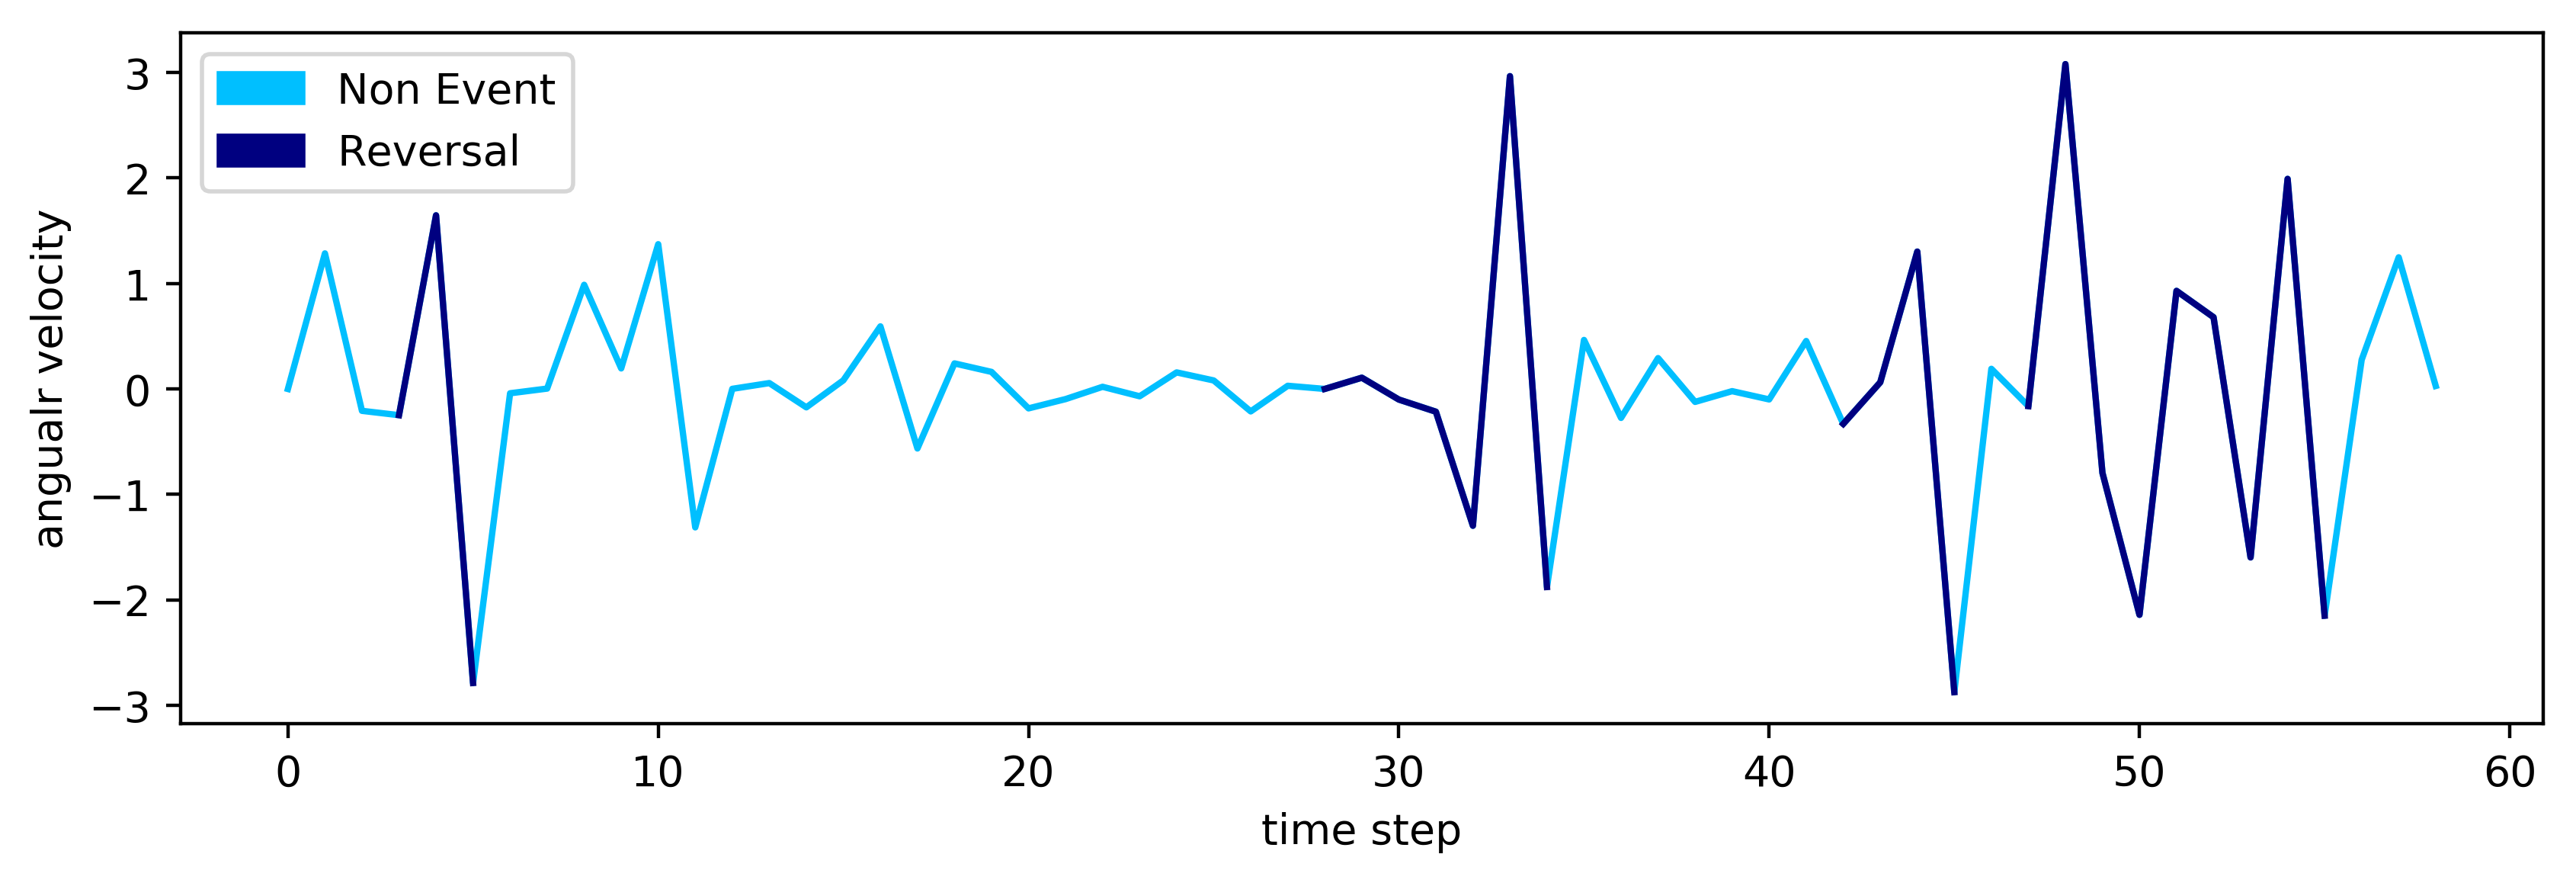

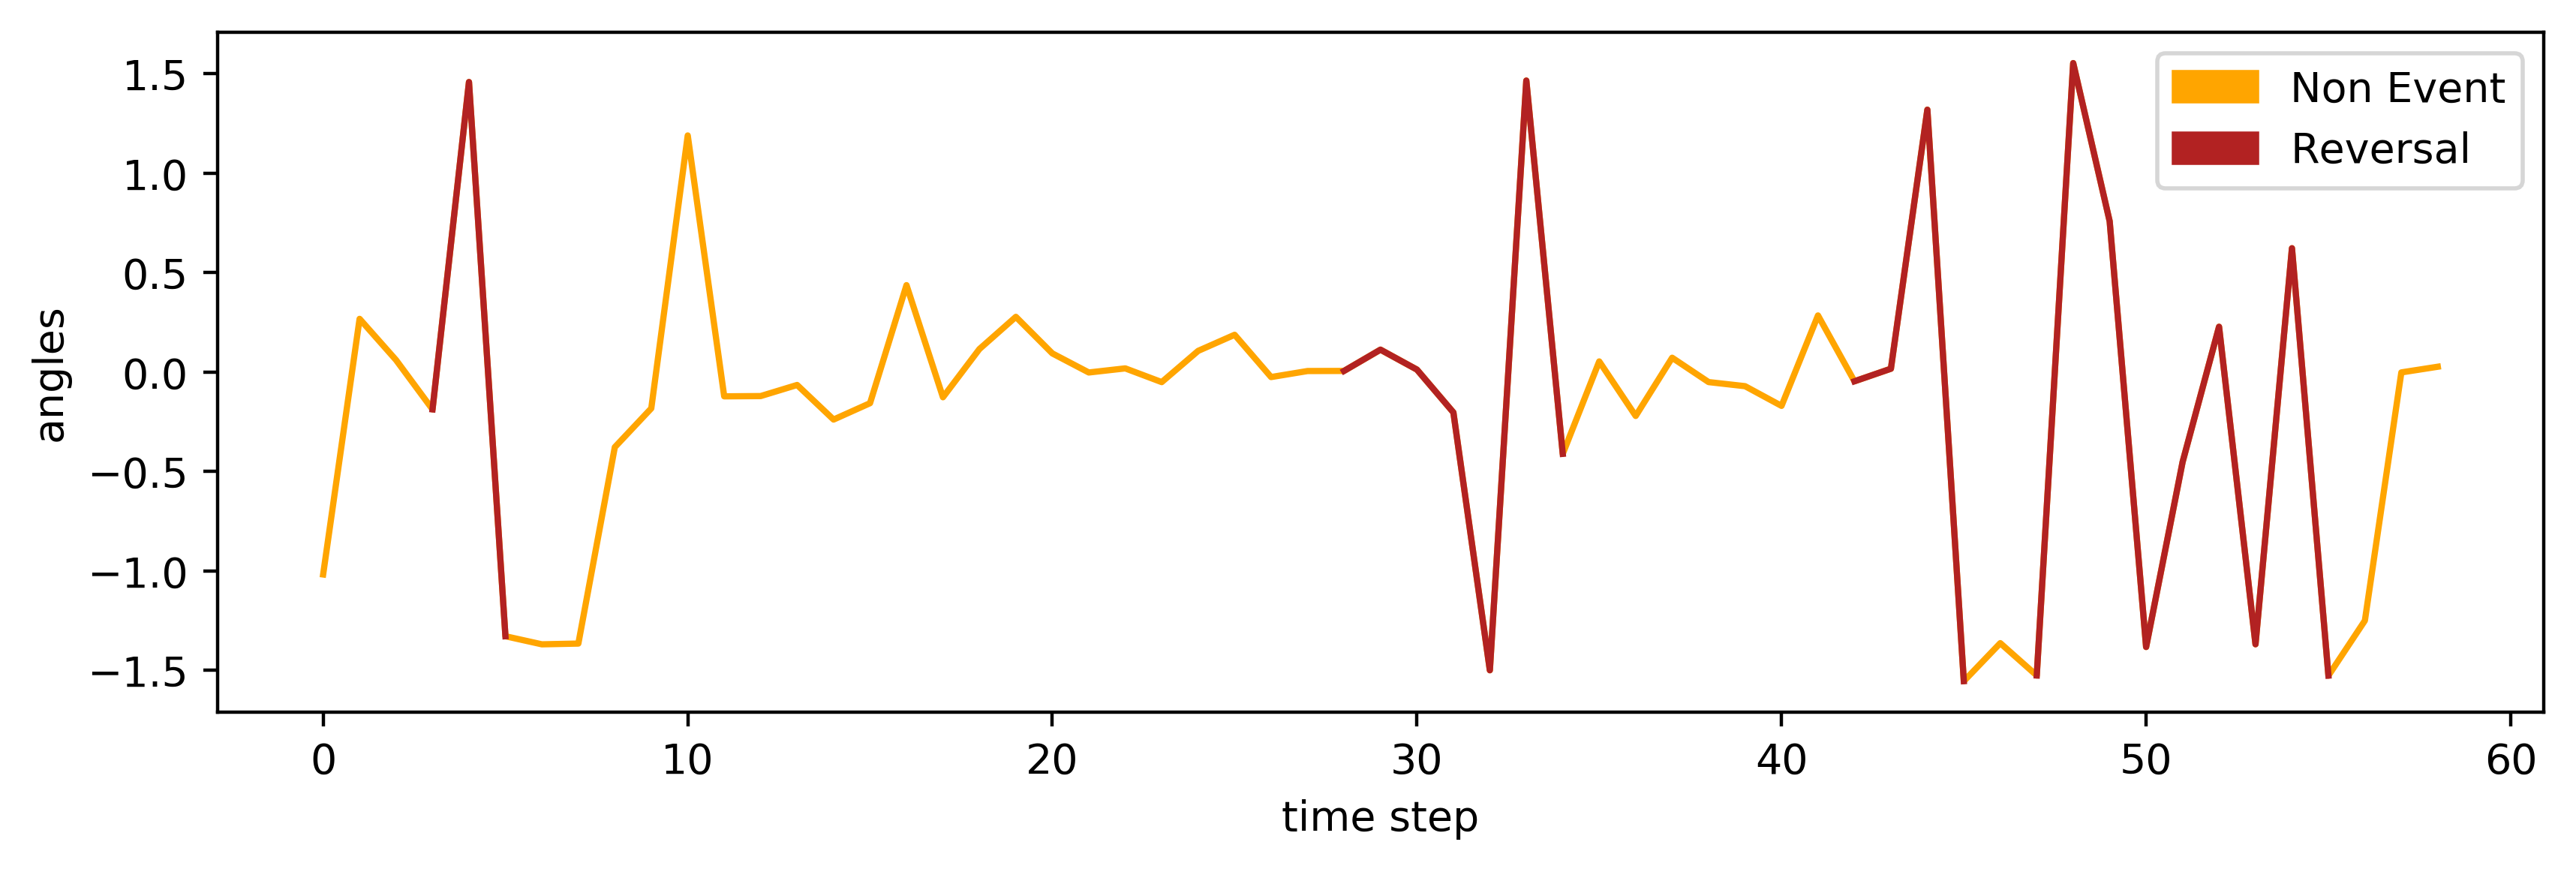

In [566]:
data = np.load('x.npy') 
data = data[500, :, :]
ang = data[:,1]
av = data[:,2]
PlotReversal(ang, av)

minIdx: [ 3  5  9 11 14 17 20 23 26 28 32 34 36 38 40 42 45 47 50 53 55]
--------------------------------
starting index: 3
ending index: 5
max: 1.45876525386
min: -1.32822426657
delta angle: 2.78698952043
delta angle must larger than: 0.5715476066494083
Marked time steps: 3 to 5
--------------------------------
starting index: 5
ending index: 9
max: -0.182378708076
min: -1.36888236226
delta angle: 1.18650365418
delta angle must larger than: 0.8082903768654761
--------------------------------
starting index: 9
ending index: 11
max: 1.19014330533
min: -0.182378708076
delta angle: 1.37252201341
delta angle must larger than: 0.5715476066494083
--------------------------------
starting index: 11
ending index: 14
max: -0.0646469795779
min: -0.23861490979
delta angle: 0.173967930212
delta angle must larger than: 0.7000000000000001
--------------------------------
starting index: 14
ending index: 17
max: 0.437385680227
min: -0.23861490979
delta angle: 0.676000590017
delta angle must larger th

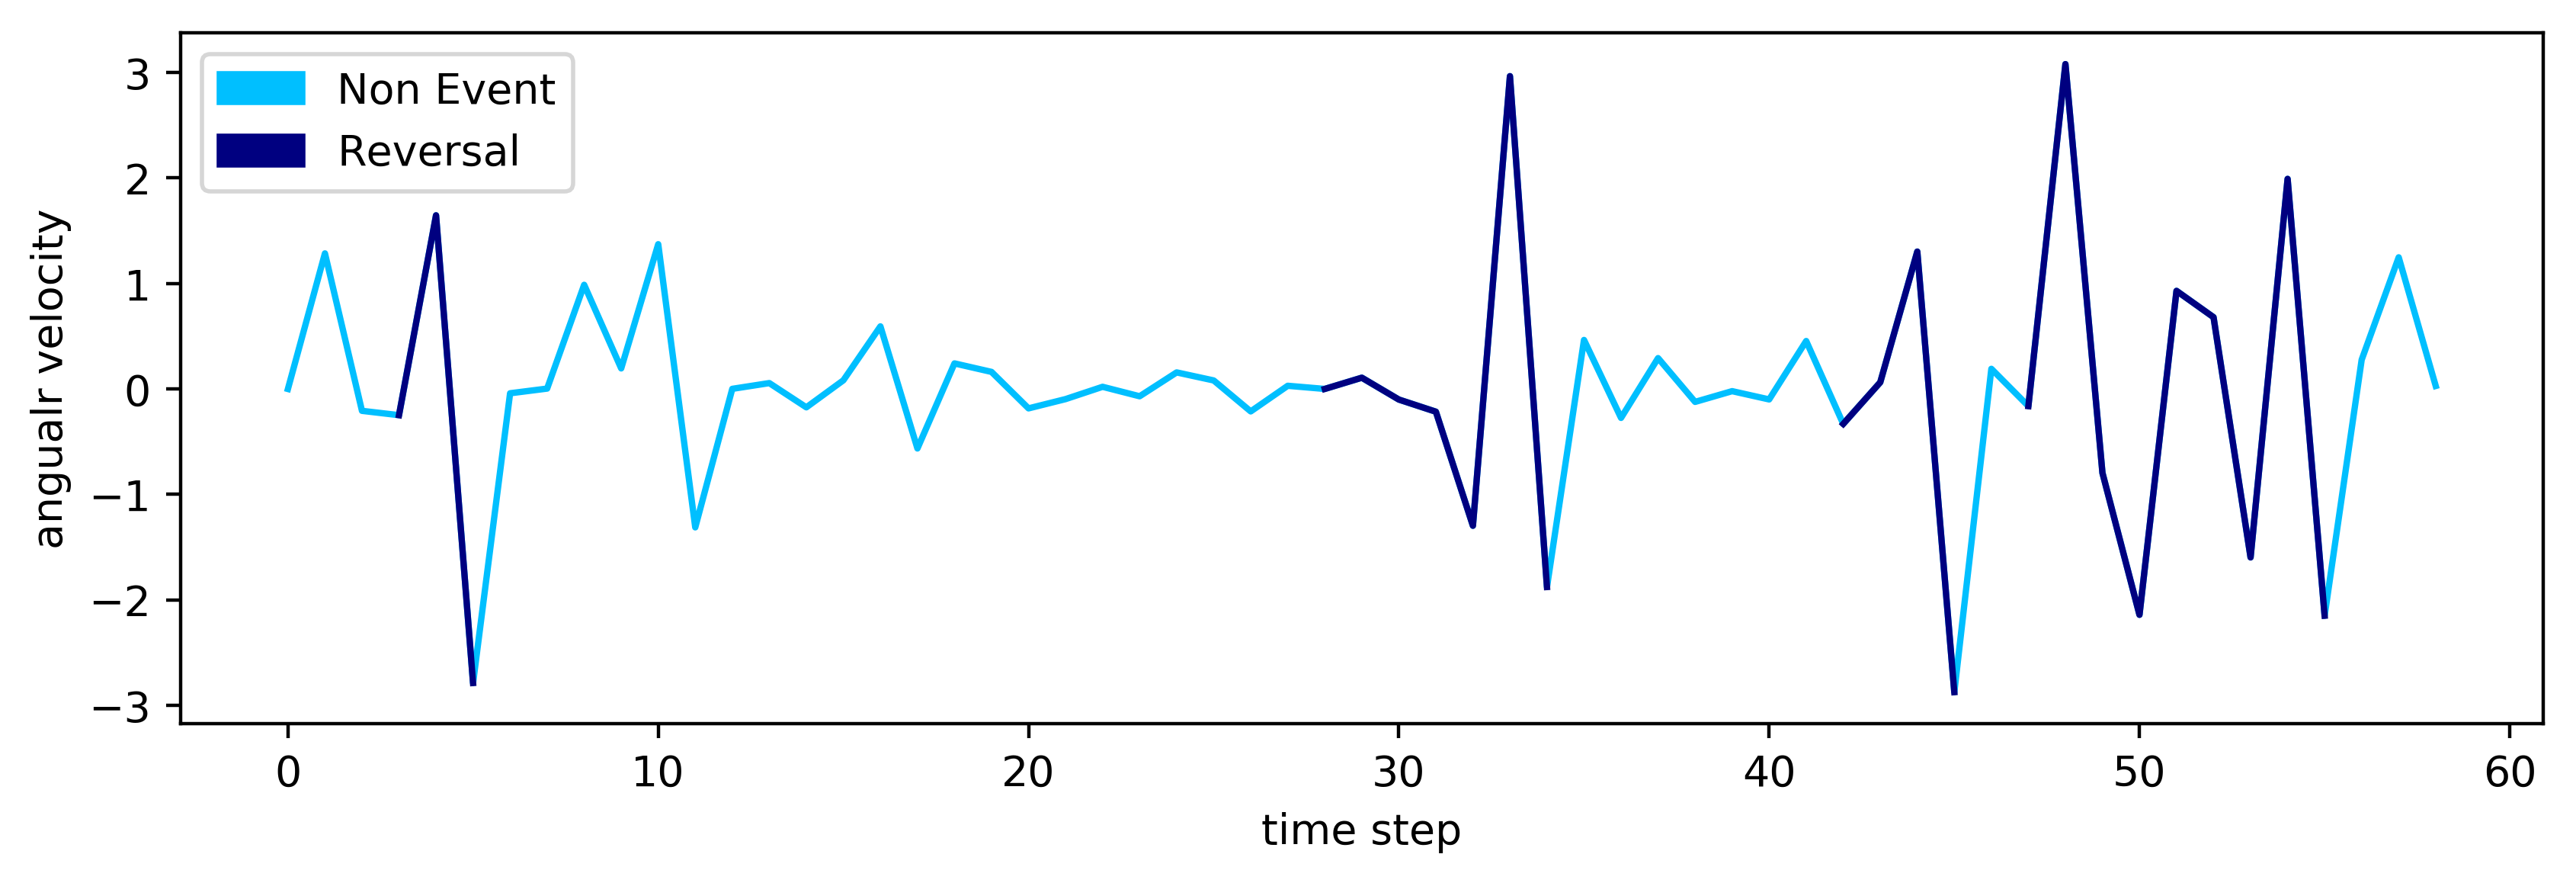

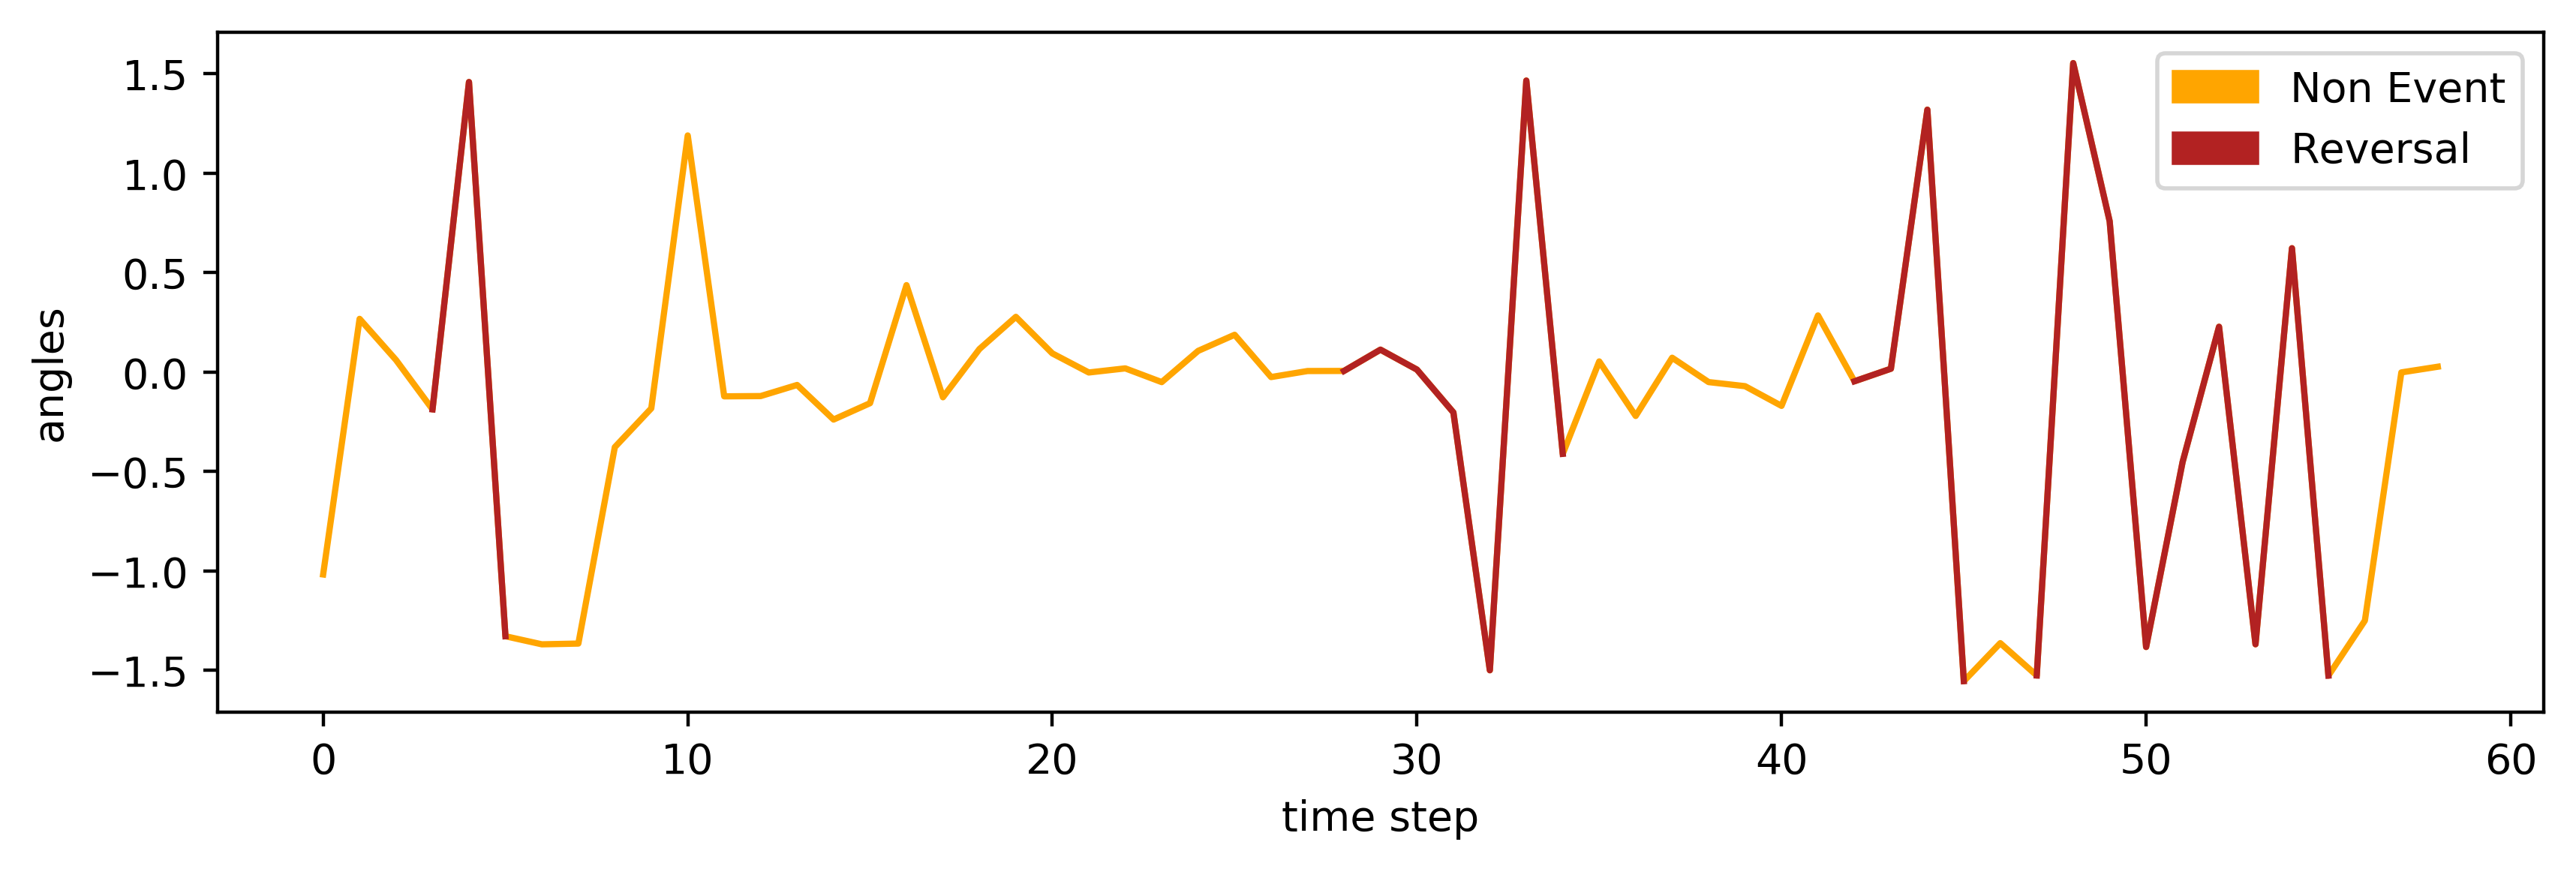

In [567]:
PlotReversal(ang, av)

In [ ]:
data = np.load('x.npy') 
data = data[100, :, :]
v = data[:,0]
PlotPause(v)

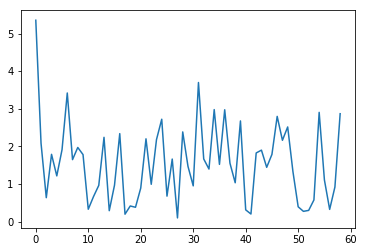

In [470]:
#[ 2  4  7 10 14 17 19 22 25 27 30 33 35 38 41 44 47 51 56]
plt.plot(v)
plt.show()

In [483]:
for i in range(1, 3):
    print(i)

1
2
